In [ ]:
# Load the Drive helper and mount
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/"

/content/drive/My Drive


In [ ]:
#Importing few libraries
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

In [ ]:
file_path="/content/drive/My Drive/pnemonia_chest/"

In [ ]:
os.listdir(file_path)

['train', 'test', 'val']

In [ ]:
#making train,test and calidation path
train_path= file_path + "/train/"
test_path=file_path + "/test/"
val_path= file_path + "val/"

In [ ]:
os.listdir(train_path + 'NORMAL')[6]

'IM-0115-0001.jpeg'

In [ ]:

#viewing the image
single_bengin=train_path + 'NORMAL/' + 'IM-0115-0001.jpeg'

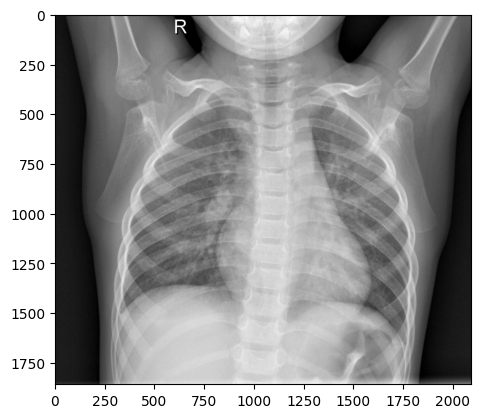

In [ ]:
bng_img=imread(single_bengin)
plt.imshow(bng_img)

In [ ]:
imread(single_bengin).shape

(1858, 2090, 3)

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_images_to_numpy(path, image_size=(256, 256), batch_size=32):
    # Initialize the ImageDataGenerator without augmentation
    datagen = ImageDataGenerator(rescale=1./255)  # Rescaling images

    # Create a generator that reads data from the specified directory
    generator = datagen.flow_from_directory(
        path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary'
    )

    # Determine the total number of images in the directory
    num_images = generator.samples

    # Initialize arrays to hold the data and labels
    data = np.zeros((num_images, image_size[0], image_size[1], 3), dtype=np.float32)
    labels = np.zeros((num_images, 1), dtype=np.float32)  # Adjusted for binary labels

    # Fill in the data and labels arrays
    i = 0
    for x_batch, y_batch in generator:
        batch_size = x_batch.shape[0]
        data[i:i+batch_size] = x_batch
        labels[i:i+batch_size] = y_batch.reshape(-1, 1)
        i += batch_size
        if i >= num_images:
            break

    return data, labels

train_data, train_labels = load_images_to_numpy(train_path)
test_data, test_labels = load_images_to_numpy(test_path)
val_data, val_labels = load_images_to_numpy(val_path)

Found 3650 images belonging to 2 classes.
Found 523 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [ ]:
print(train_data.shape)  # Should show (num_samples, 256, 256, 1) or similar
print(train_labels.shape)  # Should show (num_samples,) or similar

(3650, 256, 256, 3)
(3650, 1)


In [ ]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

In [ ]:
# Step 2: Applying SMOTE to the training data
smote = SMOTE()
train_data_res, train_labels_res = smote.fit_resample(train_data.reshape((-1, 256 * 256 * 3)), train_labels)
train_data_res = train_data_res.reshape((-1, 256, 256, 3))

In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def res_block(x, filters, kernel_size=(3, 3), activation='relu', l2_reg=0.005):  # Reduced L2 regularization
    shortcut = x
    x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(filters, (1, 1), padding='same', kernel_regularizer=l2(l2_reg))(shortcut)
    x = Add()([x, shortcut])
    x = Activation(activation)(x)
    return x

inputs = Input(shape=(256, 256, 3))
x = res_block(inputs, 16)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.10)(x)

x = res_block(x, 32)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.15)(x)

x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.20)(x)
outputs = Dense(1, activation='sigmoid')(x)

model8 = Model(inputs=inputs, outputs=outputs)
optimizer = Adam(lr=1e-4)  # Adjusted learning rate

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch > 0 and epoch % 20 == 0:
        return lr * 0.2
    return lr

lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

model8.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:

batch_size = 16



history = model8.fit(
    train_data_res,
    train_labels_res,
    epochs=100,
    batch_size=batch_size,
    validation_data=(val_data, val_labels),
    callbacks=[lr_callback,early_stopping,reduce_lr]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
339/339 [==============================] - 19s 27ms/step - loss: 0.6516 - accuracy: 0.8379 - val_loss: 1.2193 - val_accuracy: 0.7430 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
339/339 [==============================] - 8s 22ms/step - loss: 0.4462 - accuracy: 0.8892 - val_loss: 3.8243 - val_accuracy: 0.7430 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
339/339 [==============================] - 8s 22ms/step - loss: 0.3805 - accuracy: 0.9032 - val_loss: 11.0543 - val_accuracy: 0.2579 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/100
339/339 [==============================] - 8s 22ms/step - loss: 0.3394 - accuracy: 0.9128 - val_loss: 3.2649 - val_accuracy: 0.7430 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning r

In [ ]:
import matplotlib.pyplot as plt

# Evaluate the model on the test set
test_loss, test_accuracy = model8.evaluate(test_data, test_labels)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

17/17 [==============================] - 1s 24ms/step - loss: 0.0941 - accuracy: 0.9809
Test Loss: 0.09408772736787796
Test Accuracy: 0.980879545211792


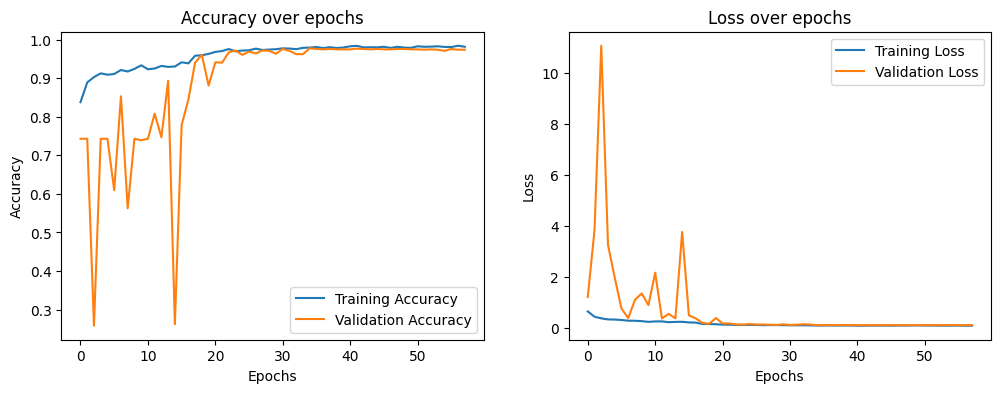

In [ ]:
# Plotting the training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot the history
plot_history(history)

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical

17/17 [==============================] - 0s 11ms/step


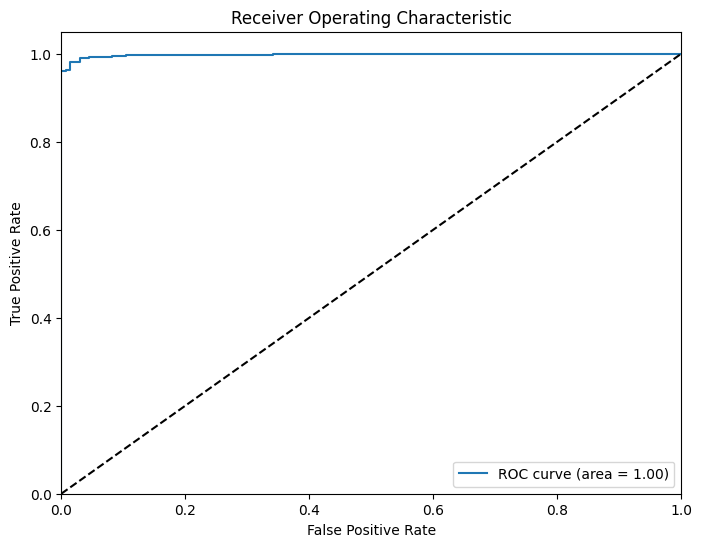

AUC:  0.9980145093547155
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.96      0.96       135
         1.0       0.98      0.99      0.99       388

    accuracy                           0.98       523
   macro avg       0.98      0.97      0.97       523
weighted avg       0.98      0.98      0.98       523

Confusion Matrix:
 [[129   6]
 [  4 384]]
Sensitivity:  0.9896907216494846
Specificity:  0.9555555555555556
True Negatives: 129
False Positives: 6
False Negatives: 4
True Positives: 384


In [ ]:
predictions = model8.predict(test_data)

# Convert to binary predictions
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

# Calculate the AUC
auc = roc_auc_score(test_labels, predictions)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(test_labels, predictions)

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(test_labels, predictions)

# Generate a classification report
report = classification_report(test_labels, binary_predictions)

# Calculate confusion matrix
cm = confusion_matrix(test_labels, binary_predictions)
tn, fp, fn, tp = cm.ravel()

# Sensitivity (recall for the positive class)
sensitivity = tp / (tp + fn)

# Specificity
specificity = tn / (tn + fp)

# Now, plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print all the metrics
print('AUC: ', auc)
print('Classification Report:\n', report)
print('Confusion Matrix:\n', cm)
print('Sensitivity: ', sensitivity)
print('Specificity: ', specificity)
print(f'True Negatives: {tn}')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')
print(f'True Positives: {tp}')


K-FOLD CROSS VALIDATION

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

def res_block(x, filters, kernel_size=(3, 3), activation='relu', l2_reg=0.005):
    shortcut = x
    x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(filters, (1, 1), padding='same', kernel_regularizer=l2(l2_reg))(shortcut)
    x = Add()([x, shortcut])
    x = Activation(activation)(x)
    return x


def create_model():
    inputs = Input(shape=(256, 256, 3))
    x = res_block(inputs, 16)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.10)(x)

    x = res_block(x, 32)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.15)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.20)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

acc_per_fold = []
loss_per_fold = []
test_acc_per_fold = []

fold_no = 1
for train, val in kfold.split(train_data_res, train_labels_res):
    model = create_model()

    model_checkpoint_path = f'/content/drive/My Drive/pneumonia_folds_accuracy/ResCovNet_model_fold_{fold_no}.h5'
    model_checkpoint = ModelCheckpoint(model_checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
    lr_callback = LearningRateScheduler(lambda epoch, lr: lr * 0.9 if epoch % 20 == 0 else lr, verbose=1)

    print(f'Training for fold {fold_no}...')

    history = model.fit(train_data_res[train], train_labels_res[train],
                        batch_size=16,
                        epochs=100,
                        validation_data=(train_data_res[val], train_labels_res[val]),
                        callbacks=[model_checkpoint, early_stopping, reduce_lr, lr_callback])

    # Load the best model and evaluate on the test dataset
    best_model = load_model(model_checkpoint_path)
    test_scores = best_model.evaluate(test_data, test_labels, verbose=0)
    test_acc_per_fold.append(test_scores[1] * 100)

    fold_no += 1






Training for fold 1...

Epoch 1: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 1/100
272/272 [==============================] - 12s 30ms/step - loss: 0.7061 - accuracy: 0.8172 - val_loss: 1.1318 - val_accuracy: 0.4940 - lr: 9.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 2/100
  4/272 [..............................] - ETA: 5s - loss: 0.5817 - accuracy: 0.8906

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


272/272 [==============================] - 6s 24ms/step - loss: 0.4829 - accuracy: 0.8880 - val_loss: 1.9453 - val_accuracy: 0.4940 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 3/100
272/272 [==============================] - 6s 24ms/step - loss: 0.4185 - accuracy: 0.8977 - val_loss: 7.2533 - val_accuracy: 0.4940 - lr: 9.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 4/100
272/272 [==============================] - 7s 27ms/step - loss: 0.3743 - accuracy: 0.9057 - val_loss: 1.1221 - val_accuracy: 0.5668 - lr: 9.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 5/100
272/272 [==============================] - 7s 24ms/step - loss: 0.3370 - accuracy: 0.9103 - val_loss: 0.3745 - val_accuracy: 0.8894 - lr: 9.0000e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 6/100
272/272 [===========================

Training for fold 2...

Epoch 1: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 1/100
272/272 [==============================] - 12s 29ms/step - loss: 0.7002 - accuracy: 0.8299 - val_loss: 1.7451 - val_accuracy: 0.4627 - lr: 9.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 2/100
272/272 [==============================] - 7s 24ms/step - loss: 0.4701 - accuracy: 0.8901 - val_loss: 1.2260 - val_accuracy: 0.5659 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 3/100
272/272 [==============================] - 7s 24ms/step - loss: 0.4011 - accuracy: 0.9062 - val_loss: 0.4295 - val_accuracy: 0.8765 - lr: 9.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 4/100
272/272 [==============================] - 6s 24ms/step - loss: 0.3528 - accuracy: 0.9140 - val_loss: 5.3119 - val_accuracy: 0.4977 - lr: 9.0000e-04

Epoch 5: Le

Training for fold 3...

Epoch 1: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 1/100
272/272 [==============================] - 11s 28ms/step - loss: 0.6993 - accuracy: 0.8283 - val_loss: 2.7247 - val_accuracy: 0.5106 - lr: 9.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 2/100
272/272 [==============================] - 7s 24ms/step - loss: 0.4760 - accuracy: 0.8848 - val_loss: 1.0197 - val_accuracy: 0.5171 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 3/100
272/272 [==============================] - 6s 24ms/step - loss: 0.3972 - accuracy: 0.9004 - val_loss: 2.2644 - val_accuracy: 0.5134 - lr: 9.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 4/100
272/272 [==============================] - 7s 27ms/step - loss: 0.3698 - accuracy: 0.9044 - val_loss: 0.3598 - val_accuracy: 0.9069 - lr: 9.0000e-04

Epoch 5: Le

Training for fold 4...

Epoch 1: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 1/100
272/272 [==============================] - 11s 28ms/step - loss: 0.6767 - accuracy: 0.8361 - val_loss: 2.1433 - val_accuracy: 0.4940 - lr: 9.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 2/100
272/272 [==============================] - 7s 24ms/step - loss: 0.4462 - accuracy: 0.8919 - val_loss: 1.1814 - val_accuracy: 0.5088 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 3/100
272/272 [==============================] - 7s 24ms/step - loss: 0.3744 - accuracy: 0.9055 - val_loss: 0.3924 - val_accuracy: 0.9161 - lr: 9.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 4/100
272/272 [==============================] - 6s 24ms/step - loss: 0.3535 - accuracy: 0.9046 - val_loss: 2.9648 - val_accuracy: 0.4940 - lr: 9.0000e-04

Epoch 5: Le

Training for fold 5...

Epoch 1: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 1/100
272/272 [==============================] - 12s 33ms/step - loss: 0.6965 - accuracy: 0.8207 - val_loss: 1.1594 - val_accuracy: 0.4963 - lr: 9.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 2/100
272/272 [==============================] - 6s 24ms/step - loss: 0.4709 - accuracy: 0.8862 - val_loss: 5.2462 - val_accuracy: 0.5037 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 3/100
272/272 [==============================] - 6s 24ms/step - loss: 0.4168 - accuracy: 0.8908 - val_loss: 3.2549 - val_accuracy: 0.4963 - lr: 9.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 4/100
272/272 [==============================] - 7s 27ms/step - loss: 0.3566 - accuracy: 0.9152 - val_loss: 0.6516 - val_accuracy: 0.6854 - lr: 9.0000e-04

Epoch 5: Le

In [ ]:
# Select the best model based on test dataset accuracy
best_fold_index = np.argmax(test_acc_per_fold)
print(f'Best model is from fold {best_fold_index + 1} with test accuracy of {test_acc_per_fold[best_fold_index]:.2f}%')

Best model is from fold 1 with test accuracy of 98.09%


In [ ]:
# After all folds are completed, you can print or analyze your accuracies
print("Validation Accuracies per Fold:", acc_per_fold)
print("Test Accuracies per Fold:", test_acc_per_fold)

Validation Accuracies per Fold: []
Test Accuracies per Fold: [98.0879545211792, 96.55831456184387, 96.94072604179382, 96.94072604179382, 96.55831456184387]


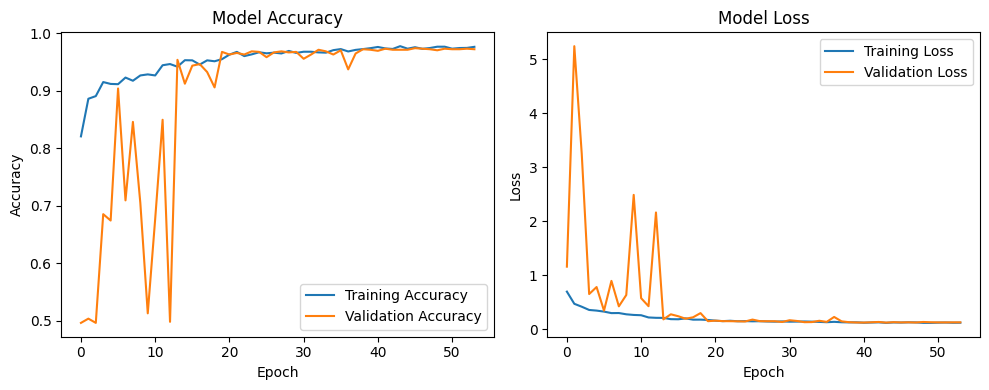

In [ ]:

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

ABLATION STUDY

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

# Residual Block without L2 regularization
def res_block_no_l2(x, filters, kernel_size=(3, 3), activation='relu'):
    shortcut = x
    x = Conv2D(filters, kernel_size, padding='same')(x)  # Removed L2 regularization
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)  # Removed L2 regularization
    x = BatchNormalization()(x)

    shortcut = Conv2D(filters, (1, 1), padding='same')(shortcut)  # Removed L2 regularization
    x = Add()([x, shortcut])
    x = Activation(activation)(x)
    return x

# Building the model without L2 regularization and Dropout
inputs = Input(shape=(256, 256, 3))
x = res_block_no_l2(inputs, 16)
x = MaxPooling2D((2, 2))(x)
# Dropout removed

x = res_block_no_l2(x, 32)
x = MaxPooling2D((2, 2))(x)
# Dropout removed

x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
# Dropout removed
outputs = Dense(1, activation='sigmoid')(x)

ResGenRegNet_model_no_l2_dropout = Model(inputs=inputs, outputs=outputs)
ResGenRegNet_model_no_l2_dropout.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch > 0 and epoch % 20 == 0:
        return lr * 0.2
    return lr

lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)


In [ ]:
# Adjust the batch size according to your system's capabilities
batch_size = 16

history2 = ResGenRegNet_model_no_l2_dropout.fit(
    train_data_res,
    train_labels_res,
    epochs=100,
    batch_size=batch_size,  # Adjust this parameter
    validation_data=(val_data, val_labels),
    callbacks=[lr_callback,early_stopping,reduce_lr]
)


Epoch 1: LearningRateScheduler setting learning rate to 9.999999974752427e-07.
Epoch 1/100
339/339 [==============================] - 8s 23ms/step - loss: 0.0614 - accuracy: 0.9795 - val_loss: 0.0943 - val_accuracy: 0.9626 - lr: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 9.999999974752427e-07.
Epoch 2/100
339/339 [==============================] - 7s 20ms/step - loss: 0.0636 - accuracy: 0.9768 - val_loss: 0.0961 - val_accuracy: 0.9607 - lr: 1.0000e-06

Epoch 3: LearningRateScheduler setting learning rate to 9.999999974752427e-07.
Epoch 3/100
339/339 [==============================] - 7s 20ms/step - loss: 0.0617 - accuracy: 0.9790 - val_loss: 0.0955 - val_accuracy: 0.9616 - lr: 1.0000e-06

Epoch 4: LearningRateScheduler setting learning rate to 9.999999974752427e-07.
Epoch 4/100
339/339 [==============================] - 7s 20ms/step - loss: 0.0634 - accuracy: 0.9784 - val_loss: 0.0941 - val_accuracy: 0.9616 - lr: 1.0000e-06

Epoch 5: LearningRateScheduler sett

In [ ]:
import matplotlib.pyplot as plt

# Evaluating the model on the test set
test_loss, test_accuracy = ResGenRegNet_model_no_l2_dropout.evaluate(test_data, test_labels)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

17/17 [==============================] - 0s 13ms/step - loss: 0.0717 - accuracy: 0.9751
Test Loss: 0.07173369824886322
Test Accuracy: 0.9751434326171875


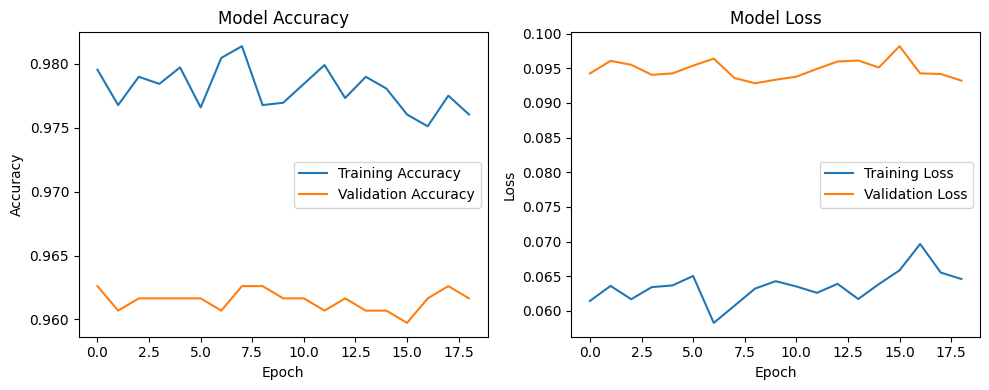

In [ ]:
# Example plotting code for training/validation accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

17/17 [==============================] - 0s 11ms/step


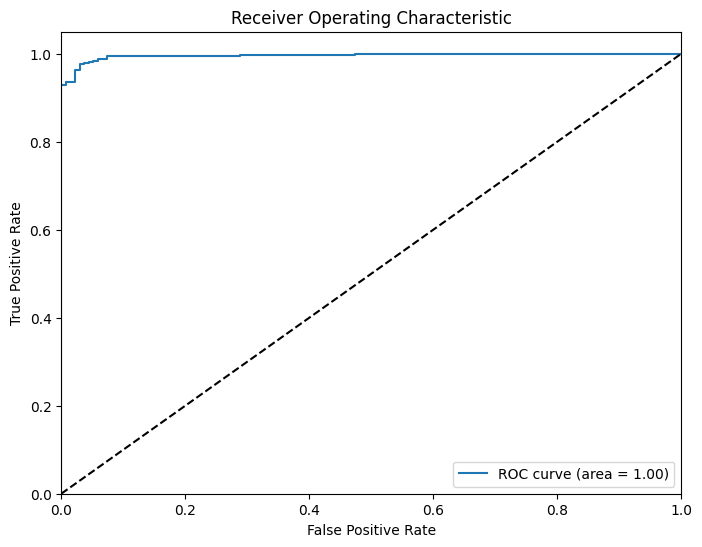

AUC:  0.9958953799159984
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.96      0.95       135
         1.0       0.98      0.98      0.98       388

    accuracy                           0.98       523
   macro avg       0.97      0.97      0.97       523
weighted avg       0.98      0.98      0.98       523

Confusion Matrix:
 [[129   6]
 [  7 381]]
Sensitivity:  0.9819587628865979
Specificity:  0.9555555555555556
True Negatives: 129
False Positives: 6
False Negatives: 7
True Positives: 381


In [ ]:
predictions = ResGenRegNet_model_no_l2_dropout.predict(test_data)

# Convert to binary predictions
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

# Calculate the AUC
auc = roc_auc_score(test_labels, predictions)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(test_labels, predictions)

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(test_labels, predictions)

# Generate a classification report
report = classification_report(test_labels, binary_predictions)

# Calculate confusion matrix
cm = confusion_matrix(test_labels, binary_predictions)
tn, fp, fn, tp = cm.ravel()

# Sensitivity (recall for the positive class)
sensitivity = tp / (tp + fn)

# Specificity
specificity = tn / (tn + fp)

# Now, plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print all the metrics
print('AUC: ', auc)
print('Classification Report:\n', report)
print('Confusion Matrix:\n', cm)
print('Sensitivity: ', sensitivity)
print('Specificity: ', specificity)
print(f'True Negatives: {tn}')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')
print(f'True Positives: {tp}')
